In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import json
import statsmodels.api as sm
import scipy.stats as st
import powerlaw
from adjustText import adjust_text
plt.style.use('seaborn-v0_8')

# Importing and Cleaning data

In [2]:
def cleanDf(df):
    # Dropping NaNs
    df.columns = ['Recipient', 'Supplier','Year of order', 'Year of order estimate','Number ordered', 
                  'Number ordered estimate', 'Weapon designation', 'Weapon description', 'Number delivered',
                    'Number delivered estimate', 'Year(s) of delivery', 'status', 'Comments', 'SIPRI TIV per unit',
                      'SIPRI TIV for total order', 'SIPRI TIV of delivered weapons']
    
    df['Year of order estimate'] = df['Year of order estimate'].notna()
    df['Number ordered estimate'] = df['Number ordered estimate'].notna()
    df['Number delivered estimate'] = df['Number delivered estimate'].notna()


    df = df.dropna(subset=['Number ordered','Number delivered','Year of order'])
    df['Number ordered'] = df['Number ordered'].astype('int')
    df['Number delivered'] = df['Number delivered'].astype('int')
    df['Year of order'] = df['Year of order'].astype('int')
    #df['Delivery start'] = df['Year(s) of delivery'].str.split(';').min()
    #df['Delivery end'] = df['Year(s) of delivery'].str.split(';').max()


    #Removing nonstate actors
    df = df[~df['Recipient'].str.contains('\*') & ~df['Supplier'].str.contains('\*')]

    #RESTRICT FOR YEARS [subject to change]
    df = df[df['Year of order'] >2001]

    #Lower designations
    df['Weapon description'] = df['Weapon description'].str.lower()

    #RESTRICT FOR NEW OR MODERNIZED
    df = df[df['status'] != 'Second hand']

    return df

In [3]:
category_list = ['aircraft', 'armoured_vehicle', 'artillery','engines','missiles','naval_weapons','sensors','ships']
full_df = pd.DataFrame()
for category in category_list:
    this_df = cleanDf(pd.read_csv("data/"+ category +".csv",encoding='Latin1'))
    this_df['Weapon Category'] = category
    full_df = pd.concat((full_df, this_df),axis=0)
full_df.head(1)
all_designations = full_df['Weapon description'].unique()

In [4]:
def create_network(df:pd.DataFrame) -> nx.digraph:
    df = df.copy(deep=True)
    with open('nodelist/nodelist_2001.json','r') as json_file:
        nodelist = json.load(json_file)
    df = df[['Recipient','Supplier','SIPRI TIV of delivered weapons']]

    df = df[df['Recipient'].isin(nodelist) & df['Supplier'].isin(nodelist)]
    
    df = df.groupby(['Recipient','Supplier'])['SIPRI TIV of delivered weapons'].sum().to_frame().reset_index()
    
    network = nx.from_pandas_edgelist(df, 'Supplier', 'Recipient', edge_attr='SIPRI TIV of delivered weapons', create_using=nx.DiGraph())
    return network

Powerlaw Test advantages:
- More rigor:
    - Conducts hypothesis test relative to similar looking distributions
    - Uses KS-Test, which (this paper found) is more suitable than bootstrapping for analyzing real world patterns

What powerlaw means:


## Counting the Number of Nodes in Each Category

In [5]:
def merge_categories(df:pd.DataFrame,investigating_categories:list):
    #investigating categories, where each element can be a string or list of strings joining categories
    df = df.copy(deep=True)

    #initialize std_unit_TIV calculation
    unit_TIV_per_category = df.groupby(['Weapon description','Weapon designation'])['SIPRI TIV per unit'].mean().groupby('Weapon description').mean()

    std_unit_TIV = {}
    avg_unit_TIV = {}

    for index, category in enumerate(investigating_categories): #joins
        assert type(category) == tuple
        #find average unit TIV
        std_unit_TIV[category[0]] = unit_TIV_per_category.loc[category[1]].std()/unit_TIV_per_category.loc[category[1]].mean()
        avg_unit_TIV[category[0]] = unit_TIV_per_category.loc[category[1]].mean()

        #combine category labels
        for category_to_combine in category[1]:
            if df[df['Weapon description'] == category_to_combine].empty:
                print("Spelling error at " + category_to_combine)
            df.loc[df['Weapon description'] == category_to_combine,'Weapon description'] = category[0] #resets category name
        investigating_categories[index] = category[0] # replace new joint category

    avg_unit_TIV = pd.Series(avg_unit_TIV)
    avg_unit_TIV = avg_unit_TIV.sort_values()
    std_unit_TIV = pd.Series(std_unit_TIV)[avg_unit_TIV.keys()]
    investigating_categories = avg_unit_TIV.keys() #reorder investigating categories by technological sophistication

    
    return df[df['Weapon description'].isin(investigating_categories)], investigating_categories, pd.Series(std_unit_TIV), pd.Series(avg_unit_TIV)

"""
['trainer/combat aircraft', 'transport aircraft','light transport aircraft', 'light aircraft','fga aircraft','maritime patrol aircraft', 'trainer/light aircraft',
              'trainer aircraft', 'tanker/transport aircraft', 'aew&c aircraft','heavy transport aircraft', 'fga/ew aircraft', 'sigint aircraft','asw aircraft', 'fighter aircraft', 'reconnaissance aircraft','ags aircraft']
"""


#TODO: Define Categories to Investigate
full_df, investigating_categories, std_unit_TIV, avg_unit_TIV = merge_categories(
    full_df,[('Armoured Vehicle',['ifv','apc','apv','apc/apv']),
             ('Helicopter', ['helicopter','combat helicopter','transport helicopter','light helicopter','asw helicopter','anti-ship helicopter','aew helicopter','transport ac/helicopter']),
             ('Heavy Fixed-Wing Aircraft', ['fga aircraft','tanker/transport aircraft', 'aew&c aircraft','heavy transport aircraft', 'fga/ew aircraft', 'sigint aircraft','asw aircraft','ags aircraft']),
             ('Light Fixed-Wing Aircraft',['light transport aircraft','light aircraft','trainer/light aircraft','trainer aircraft','maritime patrol aircraft','reconnaissance aircraft','uav','transport aircraft','fighter aircraft']),
             ('Tank/Fire-Support Vehicle', ['tank','light tank','tank destroyer','afsv','arv','armoured bridgelayer', 'aev','aev/arv']),
             ('Artillery', ['self-propelled gun chassis','towed gun','mortar', 'self-propelled gun', 'self-propelled mortar','self-propelled mrl','towed mrl','spg turret', 'mortar turret'])])


avg_unit_TIV

Armoured Vehicle              0.394546
Artillery                     0.755279
Tank/Fire-Support Vehicle     1.631740
Light Fixed-Wing Aircraft     7.572647
Helicopter                   15.552356
Heavy Fixed-Wing Aircraft    66.800319
dtype: float64

In [6]:
std_unit_TIV

Armoured Vehicle             1.037033
Artillery                    0.499582
Tank/Fire-Support Vehicle    0.460606
Light Fixed-Wing Aircraft    0.994170
Helicopter                   0.911570
Heavy Fixed-Wing Aircraft    0.498317
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


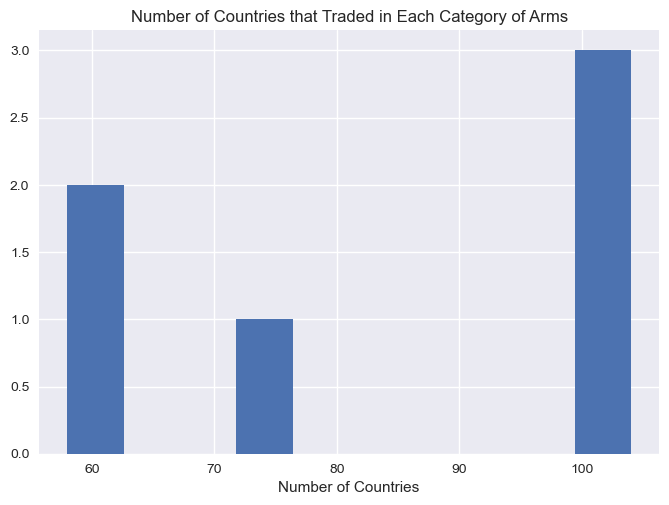

Armoured Vehicle             0.026139
Artillery                    0.022584
Tank/Fire-Support Vehicle    0.018754
Light Fixed-Wing Aircraft    0.028846
Helicopter                   0.020538
Heavy Fixed-Wing Aircraft    0.024576
dtype: float64


In [7]:
count_nodes = lambda net:len(net.nodes)
network_nodes = {}
network_density = {}

for weapon_designation in investigating_categories:
    this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
    network_nodes[weapon_designation] = count_nodes(this_network)
    network_density[weapon_designation] = nx.density(this_network)


#Node distribution graph
plt.hist(network_nodes.values(),align='mid')
plt.xlabel('Number of Countries')
plt.title('Number of Countries that Traded in Each Category of Arms')
# plt.axvline(149,0,1,label='149: Armoured Personnel Carriers',linestyle='--',color='green')
# plt.axvline(94,0,1,label= '94: Anti-Tank Missile',linestyle='--',color='red')
# plt.axvline(91,0,1,label= '91: Air Search Radar',linestyle='--',color='blue')
# plt.axvline(81,0,1,label= '94: Anti-Tank Missile',linestyle='--',color='red')
plt.legend()
plt.grid(True)
plt.show()

network_nodes = pd.Series(network_nodes)
network_density = pd.Series(network_density)

print(network_density[avg_unit_TIV.keys()])

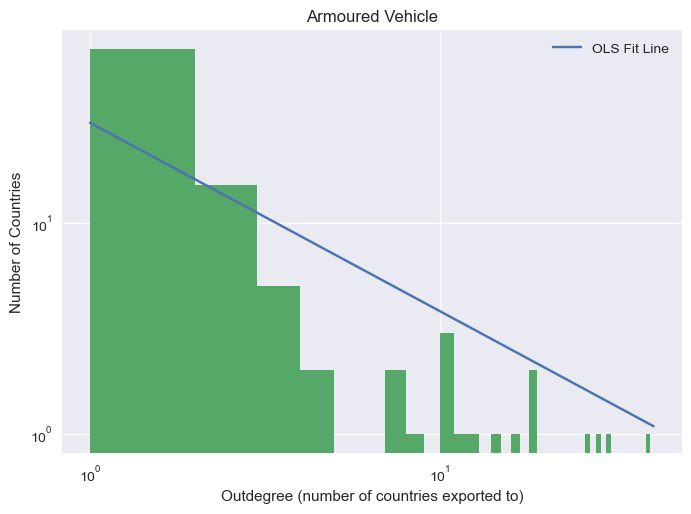

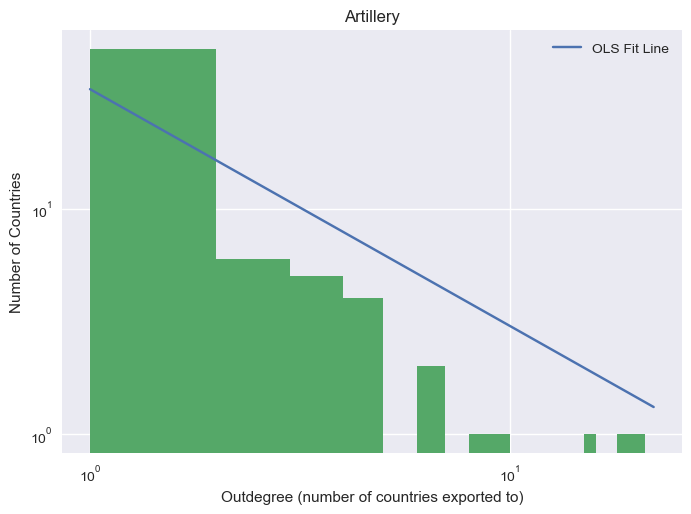

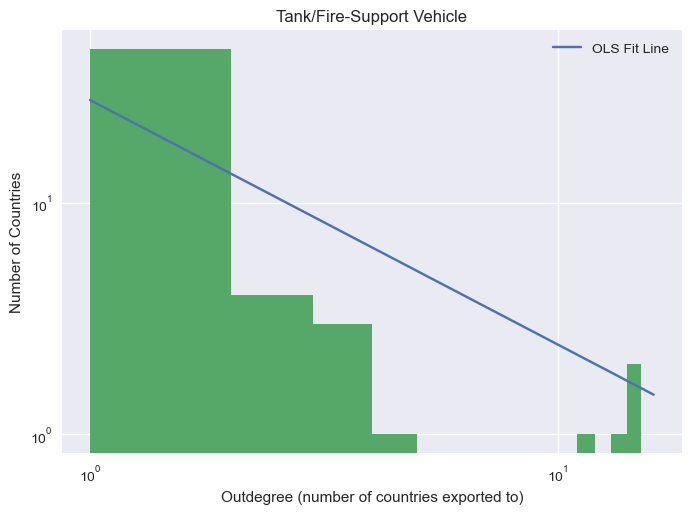

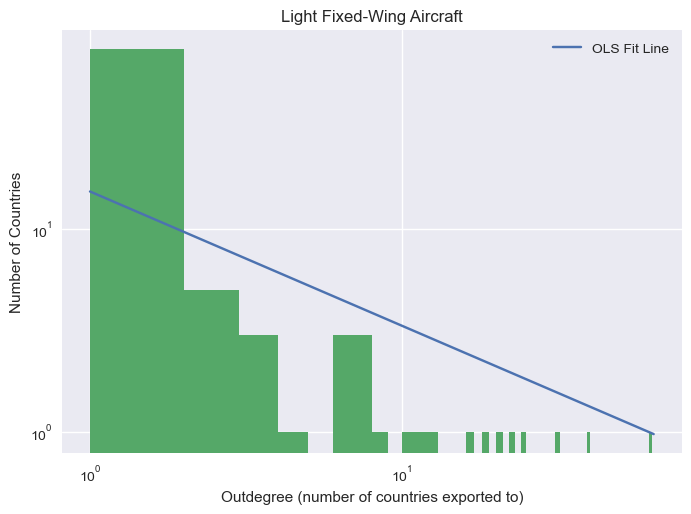

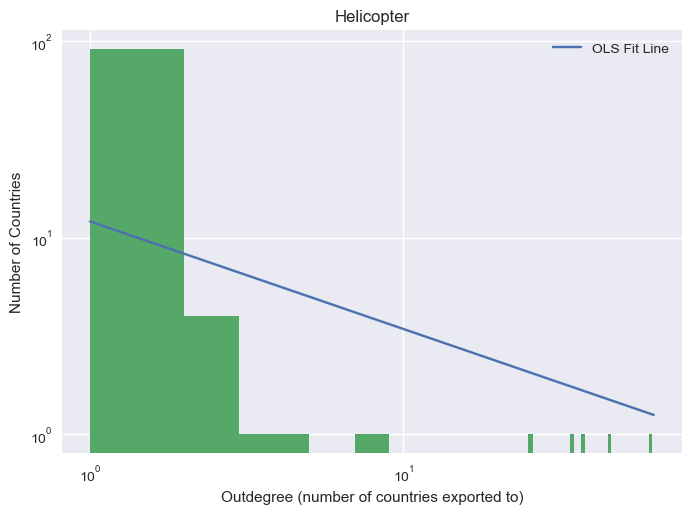

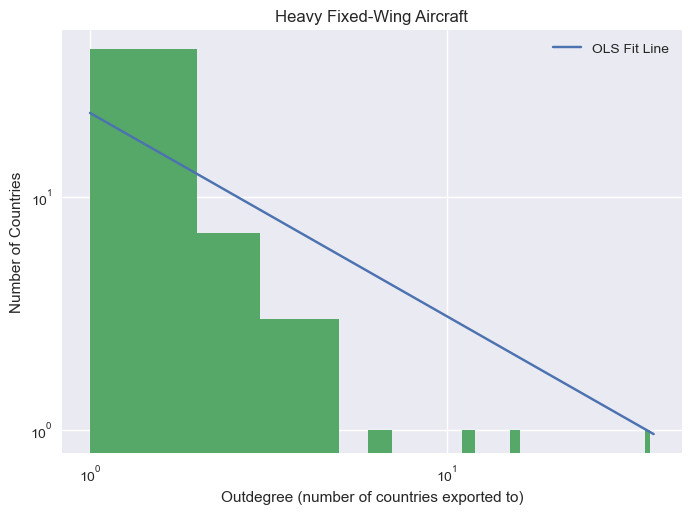

In [8]:
def powerlaw_across_categories(full_df,all_designations,plot:bool=True,distribution_to_compare:str = 'exponential'):
    def powerlaw_test(net,weighted:bool=False):
        if not weighted:
            out_degrees = dict(net.out_degree())
        else:
            out_degrees = dict(net.out_degree(weight='SIPRI TIV of delivered weapons'))
        

        out_degrees = [out_degrees[country] + 1 for country in out_degrees if out_degrees[country] >= 0]

        #data[1] = data[1][:-1] #remove last value
        #data[0] = data[0][1:] # remove first value
        #data[1] = data[1][1:] # remove first value

        if len(out_degrees) > 2:
            if out_degrees[-1] > 0:

                #Old bootstrap OLS test
                values, freq = np.unique(out_degrees, return_counts=True)
                
                Y = np.log(freq + 1)
                X = - np.log(values + 1)
                X = sm.add_constant(X)
                model = sm.OLS(Y, X)
                result = model.fit()

                #New KS powerlaw test
                fit = powerlaw.Fit(out_degrees,xmin=1,discrete=True)
                fit.distribution_compare('power_law', distribution_to_compare)

                if plot:
                    plt.title(weapon_designation)
                    plt.xlabel('Outdegree (number of countries exported to)')
                    plt.ylabel('Number of Countries')


                    #plot OLS line
                    plt.yscale('log')
                    plt.xscale('log')
                    
                    x = np.linspace(1, max(out_degrees) + 1, max(out_degrees) + 1 * 100)
                    y = np.power(np.e,result.params[0])/np.power(x,result.params[1]) # we use x - 1 to move the graph to the right by one
                    plt.plot(x,y,label='OLS Fit Line')
                    

                    #plot powerlaw line
                    """
                    # https://stats.stackexchange.com/questions/563921/maximum-likelihood-estimator-for-power-law-with-negative-exponent
                    x = np.linspace(1, max(out_degrees) + 1, max(out_degrees) + 1 * 100)
                    constant = (fit.power_law.alpha-1)*np.power(fit.xmin,fit.power_law.alpha-1 )
                    y = constant/np.power(x,fit.power_law.alpha)
                    plt.plot(x,y,label='Powerlaw Fit')
                    """
                    #fit.power_law.plot_pdf(label='Power Law Distribution Fit')


                    #plot exponential line
                    """
                    # https://stats.stackexchange.com/questions/563921/maximum-likelihood-estimator-for-power-law-with-negative-exponent
                    x = np.linspace(1, max(out_degrees) + 1, max(out_degrees) + 1 * 100)
                    constant = (fit.lognormal_positive.alpha-1)*np.power(fit.xmin,fit.lognormal_positive.alpha-1 )
                    y = constant/np.power(x,fit.lognormal_positive.alpha)
                    plt.plot(x,y,label='lognormal fit line')
                    """
                    #fit.exponential.plot_pdf(label='Exponential Distribution Fit')

                    #display graph
                    plt.hist(np.array(out_degrees),bins=range(0,max(out_degrees) + 1))
                    plt.legend()
                    plt.show()
                
                return fit.power_law.alpha, fit.D, fit.distribution_compare('power_law', distribution_to_compare, normalized_ratio=True)[0], fit.distribution_compare('power_law', distribution_to_compare, normalized_ratio=True)[1], fit.xmin, result.params[1], result.pvalues[1], result.conf_int(alpha=0.05)[1,0], result.conf_int(alpha=0.05)[1,1]
        else:
            return None,None,None,None,None,None,None
        
    results = {}
        
    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        results[weapon_designation] = powerlaw_test(this_network)

    results = pd.DataFrame.from_dict(results,orient='index',columns=['coef','D','r','p','xmin','OLS coefficient','p-value','[0.025]','[0.0975]'])
    results.dropna(inplace=True)

    return results

results = powerlaw_across_categories(full_df,investigating_categories)
results.round(5).to_csv('regression_results.csv')

### Rank Correlation Between Budget and Country's Outdegrees
- Correlation not Causation: there are fundamental market forces determining how a country performs. It's not just about GDP

In [9]:
with open('nodelist/nodelist_2001.json','r') as json_file:
    nodelist = json.load(json_file)
nodelist = dict(nodelist)

c:\Users\bings\anaconda3\envs\ir_scraper\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   Armoured Vehicle  Artillery  Tank/Fire-Support Vehicle  \
0         -0.001597   0.001602                   0.004905   
1          0.282014   0.018100                  -0.154855   
2         -0.005408  -0.012091                   0.018752   

   Light Fixed-Wing Aircraft  Helicopter  Heavy Fixed-Wing Aircraft  
0                  -0.001503   -0.001671                   0.004241  
1                   0.101013   -0.197450                  -0.113618  
2                  -0.002661    0.038548                  -0.031782  


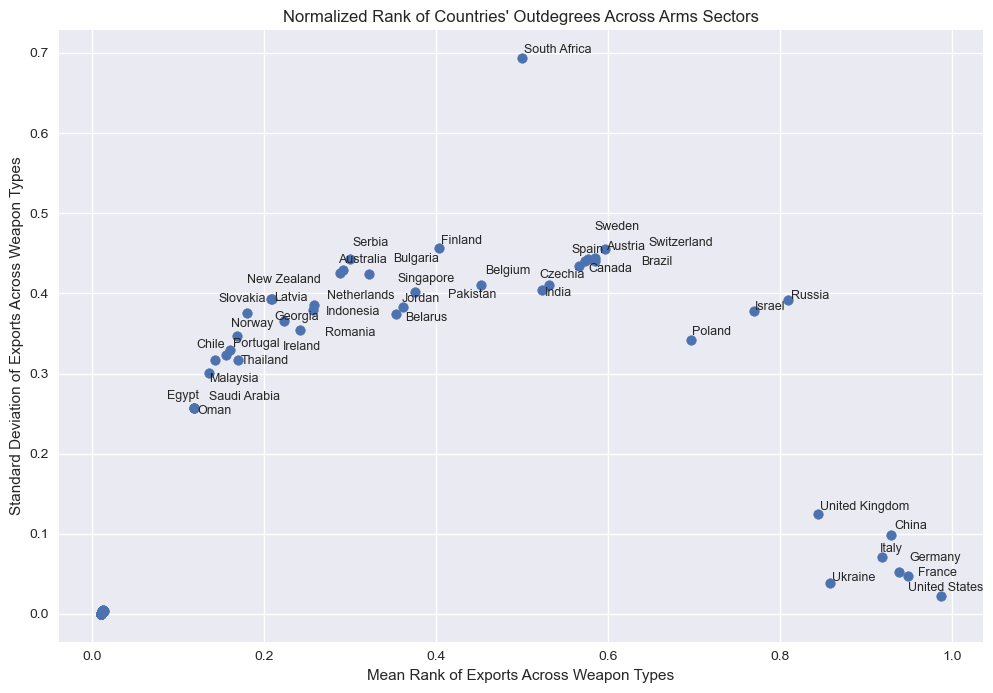

In [10]:
def mutual_correlation(full_df,all_designations):
    import scipy
    from scipy.stats import spearmanr, pearsonr, rankdata

    out_degrees = {}

    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        out_degrees[weapon_designation] = dict(this_network.out_degree())
        
    out_degrees = pd.DataFrame.from_dict(out_degrees,orient='columns').corr('spearman')

    return out_degrees



def print_corr(full_df,all_designations):
    import scipy
    from scipy.stats import spearmanr, pearsonr, rankdata

    results = {}
    rank_differences_across_sectors = pd.DataFrame(columns=all_designations)

    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        out_degrees = dict(this_network.out_degree())
        out_degrees = dict(sorted(out_degrees.items()))
        budgets = {country: nodelist[country] for country in out_degrees} # Delete budget of any countries not involved in the trade

        #Calculate Rank Differences
        budget_ranks = dict(zip(list(budgets.keys()),rankdata(list(budgets.values()))))
        degree_ranks = dict(zip(list(out_degrees.keys()),rankdata(list(out_degrees.values()))))

        rank_differences = {country : (degree_ranks[country] - budget_ranks[country]) /len(degree_ranks) for country in degree_ranks} #if positive, than higher export more than defense budget rank
        rank_differences_across_sectors[weapon_designation] = pd.Series(rank_differences)

        plt.title('Deviation from Ranked Position')
        plt.xlabel('More or Less Exports Compared to Defense Spending Rank')
        plt.hist(rank_differences.values(),label=weapon_designation)
        plt.legend()

        print(weapon_designation, scipy.stats.shapiro(list(rank_differences.values())))

        results[weapon_designation] = spearmanr(list(budgets.values()), list(out_degrees.values())), scipy.stats.shapiro(list(rank_differences.values()))
    
    rank_differences_across_sectors['mu'] = rank_differences_across_sectors[all_designations].mean(axis=1,numeric_only=True,skipna=True)
    rank_differences_across_sectors['std'] = rank_differences_across_sectors[all_designations].std(axis=1,numeric_only=True,skipna=True)
    plt.figure(figsize=(5,5))
    plt.hist(rank_differences_across_sectors['mu'])

        #, [country for country in budgets if budgets.index(country) > out_degrees.index(country)], [country for country in budgets if budgets.index(country) < out_degrees.index(country)]
    results = pd.DataFrame.from_dict(results,orient='index',columns=['spearman_corr','shapiro_on_diff'])
    return results

def compare_rankings(full_df,all_designations,weighted:bool=False):
    import scipy
    from scipy.stats import spearmanr, pearsonr, rankdata

    results = {}
    ranks_across_sectors = pd.DataFrame(columns=all_designations)

    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        if weighted:
            out_degrees = dict(this_network.out_degree(weight='SIPRI TIV of delivered weapons'))
        else: 
            out_degrees = dict(this_network.out_degree())
        out_degrees = dict(sorted(out_degrees.items()))
        budgets = {country: nodelist[country] for country in out_degrees} # Delete budget of any countries not involved in the trade

        #Calculate Rank Differences
        degree_ranks = dict(zip(list(out_degrees.keys()),rankdata(list(out_degrees.values()),method='min'))) #min or avg works; dense and max doesn't. Min or avg enlarges distinction between low-outdegrees and shrinks distinction between large outdegrees 

        degree_ranks = {country: degree_ranks[country]/len(list(out_degrees.values())) for country in degree_ranks} #normalize by length of outdegrees

        ranks_across_sectors[weapon_designation] = pd.Series(degree_ranks)
    
    ranks_across_sectors['mu'] = ranks_across_sectors[all_designations].mean(axis=1,numeric_only=True,skipna=True)
    ranks_across_sectors['std'] = ranks_across_sectors[all_designations].std(axis=1,numeric_only=True,skipna=True)
    ranks_across_sectors = ranks_across_sectors.sort_values(by='mu',ascending=False)
        
    # Conducting clustering
    
    from sklearn.cluster import SpectralClustering
    ranks_across_sectors = ranks_across_sectors.dropna(subset=['mu','std']) #drop invalid entries

    model = SpectralClustering(n_clusters=3,random_state=50)
    model.fit(ranks_across_sectors[['mu','std']])

    ranks_across_sectors['cluster'] = model.labels_


    #Plotting Std by Mean
    fig, ax = plt.subplots(figsize=(10,7))
    plt.title('Normalized Rank of Countries\' Outdegrees Across Arms Sectors')
    plt.xlabel('Mean Rank of Exports Across Weapon Types')
    plt.ylabel('Standard Deviation of Exports Across Weapon Types')
    ax.scatter(ranks_across_sectors['mu'],ranks_across_sectors['std'])
    plt.rcParams['font.size'] = 9
    plt.tight_layout()

    annotations = [ax.annotate(txt, (ranks_across_sectors['mu'].loc[txt], ranks_across_sectors['std'].loc[txt])) for txt in ranks_across_sectors.index
                   if ranks_across_sectors['mu'].loc[txt] > 0.02]# if not from zero-outdegree cluster
    adjust_text(annotations)

    #Checking for gain and loss across sectors
    
    ranks_across_sectors[all_designations] = ranks_across_sectors[all_designations].sub(ranks_across_sectors['mu'], axis=0)# get difference from mean and propagate NaNs

    gain_by_semiperiphery = {}
    for cluster in range(0,3):
        gain_by_semiperiphery[cluster] = ranks_across_sectors[ranks_across_sectors['cluster'] == cluster][all_designations].mean(axis=0).values
    gain_by_semiperiphery = pd.DataFrame.from_dict(gain_by_semiperiphery,orient='index',columns=all_designations)
    print(gain_by_semiperiphery)
    
    

        #, [country for country in budgets if budgets.index(country) > out_degrees.index(country)], [country for country in budgets if budgets.index(country) < out_degrees.index(country)]
    return ranks_across_sectors

compared_rankings = compare_rankings(full_df,investigating_categories)

### Are Some Sectors More Successful

(array([ 1.,  7.,  1.,  8., 12.,  0.,  1.,  2.,  2.,  1.]),
 array([-0.76036932, -0.62470608, -0.48904284, -0.3533796 , -0.21771636,
        -0.08205312,  0.05361012,  0.18927335,  0.32493659,  0.46059983,
         0.59626307]),
 <BarContainer object of 10 artists>)

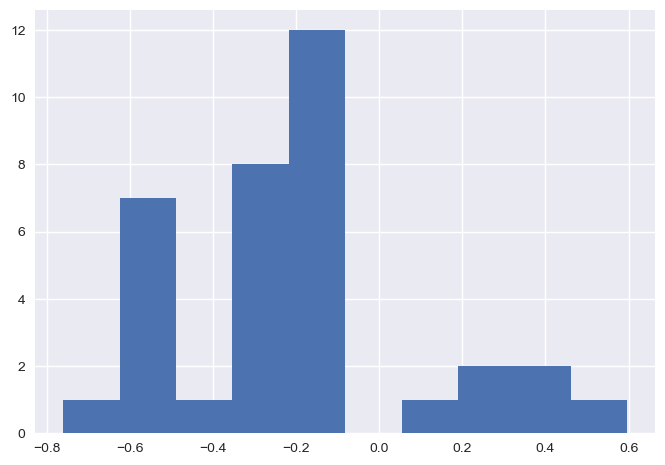

In [11]:
plt.hist(compared_rankings[compared_rankings['cluster'] == 1]['Helicopter'])

In [32]:
compared_rankings.head(10)

,Armoured Vehicle,Artillery,Tank/Fire-Support Vehicle,Light Fixed-Wing Aircraft,Helicopter,Heavy Fixed-Wing Aircraft,mu,std,cluster
United States,0.013125,-0.013902,-0.038599,0.013125,0.013125,0.013125,0.986875,0.021782,2
France,0.022467,0.010773,NaN,-0.083302,0.032082,0.017980,0.948687,0.047203,2
Germany,0.013522,-0.032995,0.061599,0.023138,0.023138,-0.088401,0.938401,0.052823,2
China,0.051794,0.071025,0.036542,0.013333,0.022948,-0.195642,0.928975,0.098023,2
Italy,0.033748,-0.134391,0.012860,0.052979,0.052979,-0.018175,0.918175,0.071147,2
Ukraine,0.026664,-0.074168,0.021359,0.007433,0.026664,-0.007952,0.857952,0.038723,2
United Kingdom,-0.199179,0.089023,NaN,-0.045333,0.098898,0.056590,0.843410,0.125136,2
Russia,0.133250,0.136888,0.173701,-0.799442,0.181327,0.174276,0.809058,0.392180,2
Israel,0.162708,0.216502,0.040360,0.210785,-0.760369,0.130015,0.769985,0.378014,2
Poland,0.092528,0.006769,0.183377,0.169451,0.227143,-0.679267,0.695934,0.341744,2


In [33]:
compared_rankings.loc[['Russia','Israel','Poland'],'cluster'] = 2 # make upper middle-powers a great power

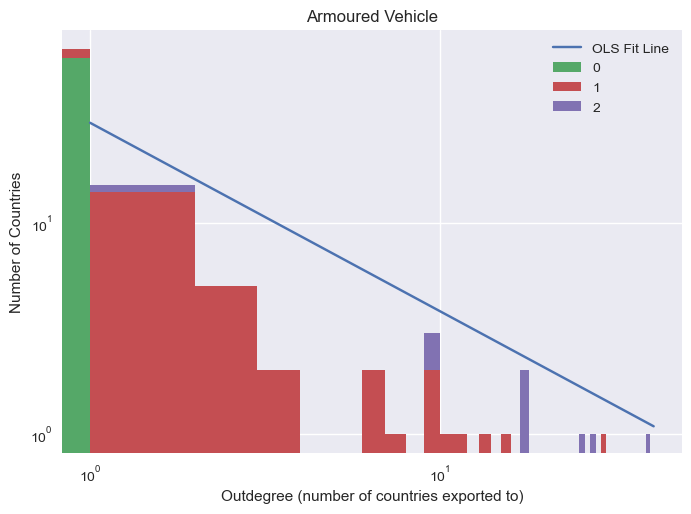

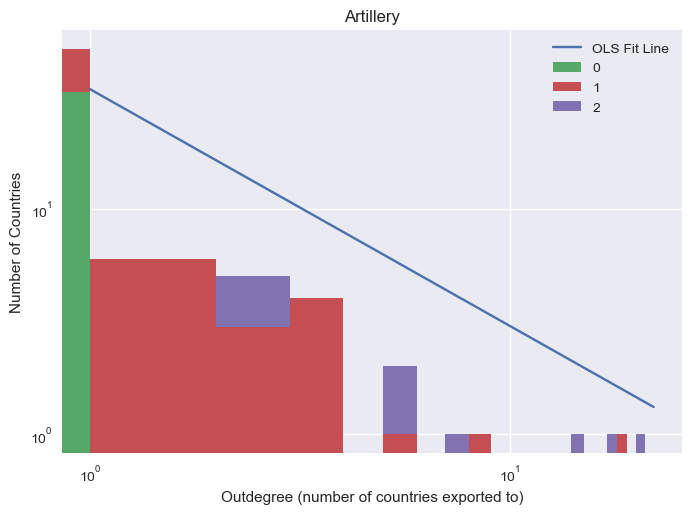

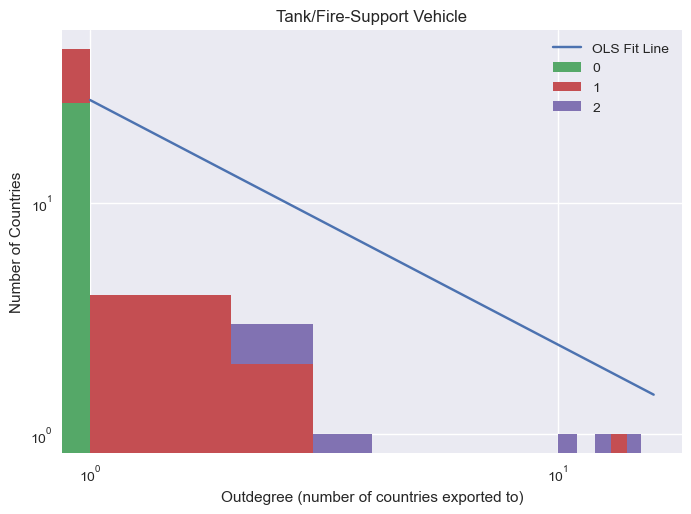

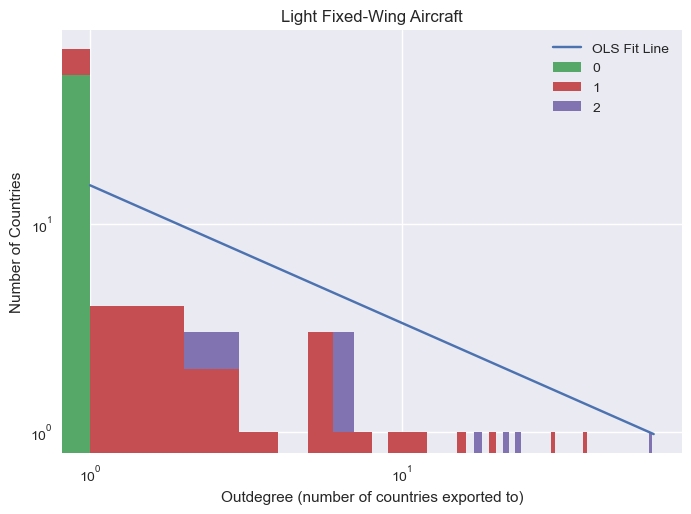

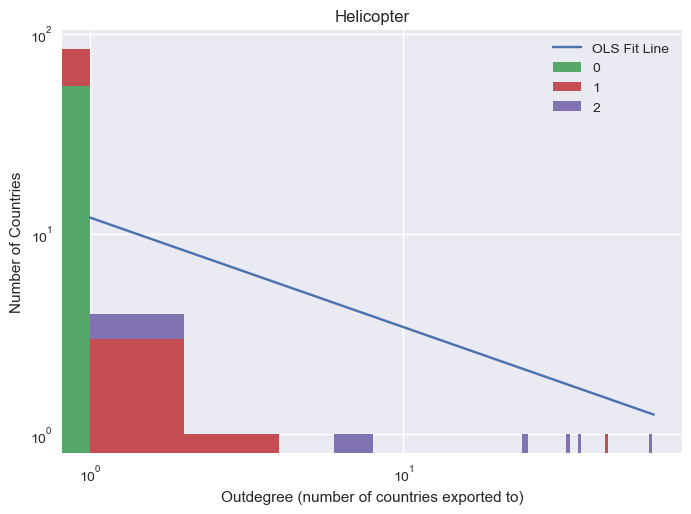

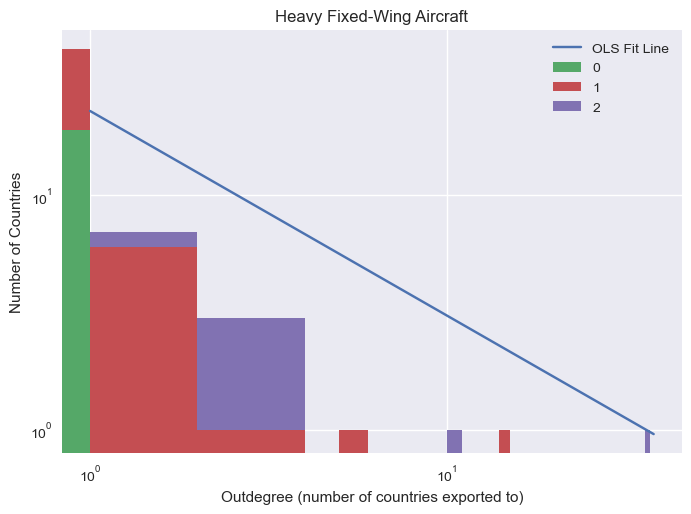

In [13]:
def plot_across_categories(full_df,all_designations,plot:bool=True,distribution_to_compare:str='exponential'):
    def powerlaw_test(net,weighted:bool=False):
        if not weighted:
            out_degrees = dict(net.out_degree())
        else:
            out_degrees = dict(net.out_degree(weight='SIPRI TIV of delivered weapons'))


        outdegree_df = pd.Series(out_degrees)
        outdegree_df = pd.merge(compared_rankings['cluster'].rename('cluster'),outdegree_df.rename('outdegree'),how='right', left_index=True,right_index=True,validate='1:1')
        out_degrees = [out_degrees[country] + 1 for country in out_degrees if out_degrees[country] >= 0]

        if len(out_degrees) > 2:
            if out_degrees[-1] > 0:

                #Old bootstrap OLS test
                values, freq = np.unique(out_degrees, return_counts=True)
                
                Y = np.log(freq + 1)
                X = - np.log(values + 1)
                X = sm.add_constant(X)
                model = sm.OLS(Y, X)
                result = model.fit()

                #New KS powerlaw test
                fit = powerlaw.Fit(out_degrees,xmin=1,discrete=True)
                fit.distribution_compare('power_law', distribution_to_compare)

                if plot:
                    plt.title(weapon_designation)
                    plt.xlabel('Outdegree (number of countries exported to)')
                    plt.ylabel('Number of Countries')


                    #plot OLS line
                    plt.yscale('log')
                    plt.xscale('log')
                    
                    x = np.linspace(1, max(out_degrees) + 1, max(out_degrees) + 1 * 100)
                    y = np.power(np.e,result.params[0])/np.power(x,result.params[1]) # we use x - 1 to move the graph to the right by one
                    plt.plot(x,y,label='OLS Fit Line')


                    #display graph
                    plt.hist([outdegree_df[outdegree_df['cluster'] == cluster]['outdegree'] for cluster in range(0,3)],bins=range(0,max(out_degrees) + 1),stacked=True,label=[0,1,2])
                    plt.legend()
                    plt.show()
                
                return fit.power_law.alpha, fit.D, fit.distribution_compare('power_law', distribution_to_compare, normalized_ratio=True)[0], fit.distribution_compare('power_law', distribution_to_compare, normalized_ratio=True)[1], fit.xmin, result.params[1], result.pvalues[1], result.conf_int(alpha=0.05)[1,0], result.conf_int(alpha=0.05)[1,1]
        else:
            return None,None,None,None,None,None,None
        
    results = {}
        
    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        results[weapon_designation] = powerlaw_test(this_network)

    results = pd.DataFrame.from_dict(results,orient='index',columns=['coef','D','r','p','xmin','OLS coefficient','p-value','[0.025]','[0.0975]'])
    results.dropna(inplace=True)

    return results

results = plot_across_categories(full_df,investigating_categories)

# Directed Betweeness

In [14]:
# Indegree Outdegree Ratios

def generate_out_in_ratio(full_df,all_designations,weighted:bool=False):
    import scipy
    from scipy.stats import spearmanr, pearsonr, rankdata

    results = {}
    ranks_across_sectors = pd.DataFrame(columns=all_designations)

    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        if weighted:
            out_degrees = dict(this_network.out_degree(weight='SIPRI TIV of delivered weapons'))
        else: 
            out_degrees = dict(this_network.out_degree())
        out_degrees = dict(sorted(out_degrees.items()))
        
        in_degrees = dict(sorted(this_network.in_degrees()))
        budgets = {country: nodelist[country] for country in out_degrees} # Delete budget of any countries not involved in the trade


# Looking at Middle-Powers

In [15]:
def betweeness_across_sectors(full_df,investigating_categories, oligopolist_cluster:int=2,middle_power_cluster:int=1, lower_cluster:int=0):
    betweeness_df = {}


    for weapon_designation in investigating_categories:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])
        print(compared_rankings[(compared_rankings['cluster'] == oligopolist_cluster) & (compared_rankings.index.isin(this_network.nodes))].index)
        
        betweenness = pd.Series(nx.betweenness_centrality_subset(this_network,
                                                                 sources = compared_rankings[((compared_rankings['cluster'] == oligopolist_cluster)|(compared_rankings['cluster'] == middle_power_cluster)) & (compared_rankings.index.isin(this_network.nodes))].index,
                                                                 targets = compared_rankings[((compared_rankings['cluster'] == middle_power_cluster) | (compared_rankings['cluster'] == lower_cluster)) & (compared_rankings.index.isin(this_network.nodes))].index,
                                                                 #targets = compared_rankings[(compared_rankings.index.isin(this_network.nodes))].index,
                                                                 normalized=True))
        this_weapon_betweeness = np.empty(3)
        for cluster in range(0,3):
            this_cluster_countries = compared_rankings[compared_rankings['cluster'] == cluster].index
            this_weapon_betweeness[cluster] = np.sum(betweenness[[country for country in this_cluster_countries if country in betweenness.index]])
        betweeness_df[weapon_designation] = this_weapon_betweeness
    betweeness_df = pd.DataFrame.from_dict(betweeness_df,orient='columns')
    return betweeness_df


betweeness = betweeness_across_sectors(full_df,investigating_categories)
betweeness.to_csv('betweeness.csv')

Index(['United States', 'France', 'Germany', 'China', 'Italy', 'Ukraine',
       'United Kingdom'],
      dtype='object')
Index(['United States', 'France', 'Germany', 'China', 'Italy', 'Ukraine',
       'United Kingdom'],
      dtype='object')
Index(['United States', 'Germany', 'China', 'Italy', 'Ukraine'], dtype='object')
Index(['United States', 'France', 'Germany', 'China', 'Italy', 'Ukraine',
       'United Kingdom'],
      dtype='object')
Index(['United States', 'France', 'Germany', 'China', 'Italy', 'Ukraine',
       'United Kingdom'],
      dtype='object')
Index(['United States', 'France', 'Germany', 'China', 'Italy', 'Ukraine',
       'United Kingdom'],
      dtype='object')


In [16]:
raise NotImplementedError

NotImplementedError: 

### Existing Findings
1. All arms trade sectors/networks are oligopolized. OLIGOPOLY IS CROSS-SECTORAL -> 
2. They are oligopolized by largely the same countries
### Further Analysis
Our independent variable will turn from contrasting arms networks to contrasting core, semi-periphery, and periphery nodes
- We have a look at in_degree/out_degree ratio. Are semi-periphery more dependent even in networks that they have a high outdegree?
- We look at betweeness centrality. Are semi-periphery nodes brokers between core and periphery nodes? Are they brokers between core - core nodes?

In [45]:

def print_clustered_graph(full_df,investigating_categories,periphery_cluster = 0,oligopolist_cluster=2): #CHECK PERIPHERY CLUSTER EVERYTIME

    export_data = {}

    for weapon_designation in investigating_categories:
        G = create_network(full_df[full_df['Weapon description'] == weapon_designation])  
        G.remove_nodes_from(list(nx.isolates(this_network)))
        #G.remove_nodes_from([node for node in G.nodes if compared_rankings['cluster'].get(node,default=periphery_cluster) == periphery_cluster]) #remove periphery nodes
        
        plt.figure(figsize=(20,20))
        plt.title('category = '+weapon_designation)
        communities = list(nx.community.greedy_modularity_communities(G,cutoff=1))
        print("Modularity score:", nx.algorithms.community.quality.modularity(G, communities))
        print("n_modules:",len(communities))

        supergraph = nx.cycle_graph(len(communities))
        superpos = nx.spring_layout(G, scale=2, seed=450)
        centers = list(superpos.values())
        pos = {}
        for center, comm in zip(centers, communities):
            pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=4360))

        #create reverse index of communities
        community_dict = {}
        for community_index, community in enumerate(communities):
            for country in community:
                community_dict[country] = community_index
        
        #calculate communities consisting of non-oligopolist nodes
        def non_oligopolist_communities(communities:list,min_size:int=5):
            non_oligopolist_dominated_communities = []
            total_big_communities = 0
            total_oligopolist_present_communities = 0
            total_oligopolist_dominated_communities = 0
            for community in communities:
                if len(community) >= min_size: #then check if the community does not contain oligopolist power
                    total_big_communities += 1
                    #check if this community contains oligopolist
                    this_community_oligopolist = False
                    for node in community:
                        try:
                            if compared_rankings.loc[node,'cluster'] == oligopolist_cluster: this_community_oligopolist = True
                        except KeyError:
                            pass
                    if this_community_oligopolist: total_oligopolist_present_communities += 1
                    
                    #check if most central node is oligopolist
                    community_graph = G.subgraph(community)
                    highest_outdegree_node = pd.Series(nx.out_degree_centrality(community_graph)).sort_values(ascending=False).index[0]
                    try:
                        if compared_rankings.loc[highest_outdegree_node,'cluster'] == oligopolist_cluster:
                            total_oligopolist_dominated_communities += 1
                        else: non_oligopolist_dominated_communities.append((pd.Series(nx.out_degree_centrality(community_graph))).sort_values(ascending=False).index)
                    except KeyError:
                        pass
            return total_big_communities, total_oligopolist_present_communities, total_oligopolist_dominated_communities, [x for x in non_oligopolist_dominated_communities]
                
        #create dataframe for data
        export_data[weapon_designation] = [nx.algorithms.community.quality.modularity(G, communities),len(communities)] + list(non_oligopolist_communities(communities))


        #nx.draw_networkx_nodes(G, pos=pos, node_color=[compared_rankings['cluster'].get(node,default=periphery_cluster) for node in G.nodes], node_size=100) #node colors by cluster
        nx.draw_networkx_nodes(G, pos=pos, node_color= np.array([community_dict[node] for node in G.nodes]) /len(communities),cmap=plt.cm.hot, node_size=100) #node colors by cluster

        nx.draw_networkx_edges(G, pos=pos)
        nx.draw_networkx_labels(G, pos, font_size=15)
        plt.tight_layout()
        plt.show()
    
    export_data = pd.DataFrame.from_dict(export_data,orient='columns')
    export_data.index = ['Modularity','Total Communities','Communities of Size >= 5','Large Communities with Oligopolists Present', 'Large Communities Dominated by an Oligopolist','Communities Without Oligopolies of Size >= 5']
    export_data.transpose().to_csv('modularity_data.csv')


def print_sat_star_graph(full_df,investigating_categories):
    for weapon_designation in investigating_categories:
        G = create_network(full_df[full_df['Weapon description'] == weapon_designation])  
        G.remove_nodes_from(list(nx.isolates(this_network)))
        
        plt.figure(figsize=(20,20))
        plt.legend()
        plt.title('category = '+weapon_designation)
        star_graph(create_using)


print_clustered_graph(full_df,investigating_categories)

In [ ]:
compared_rankings.loc[['Russia','Israel','Poland'],'cluster'] = 2

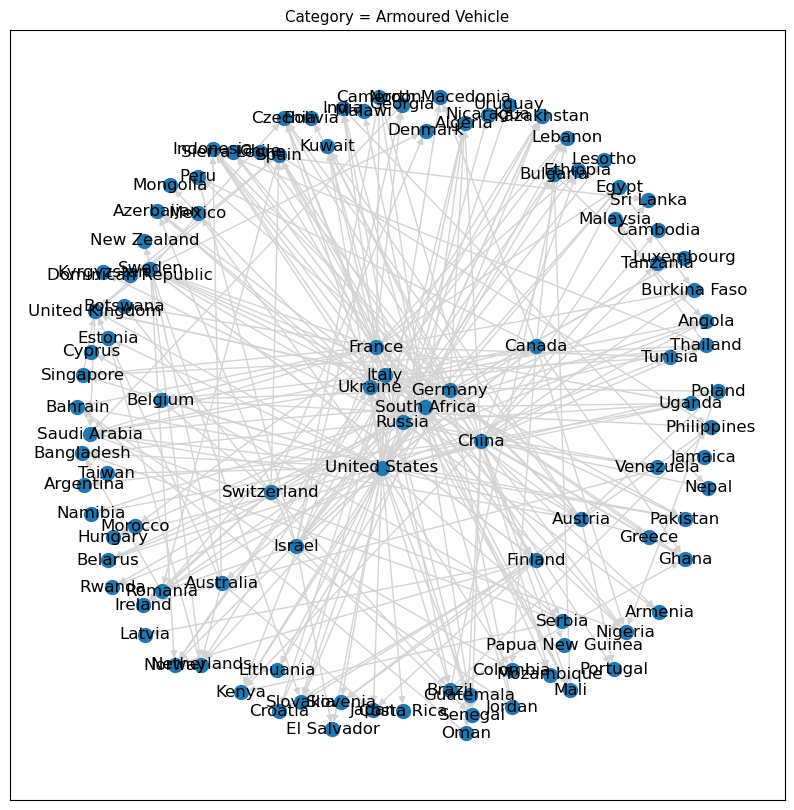

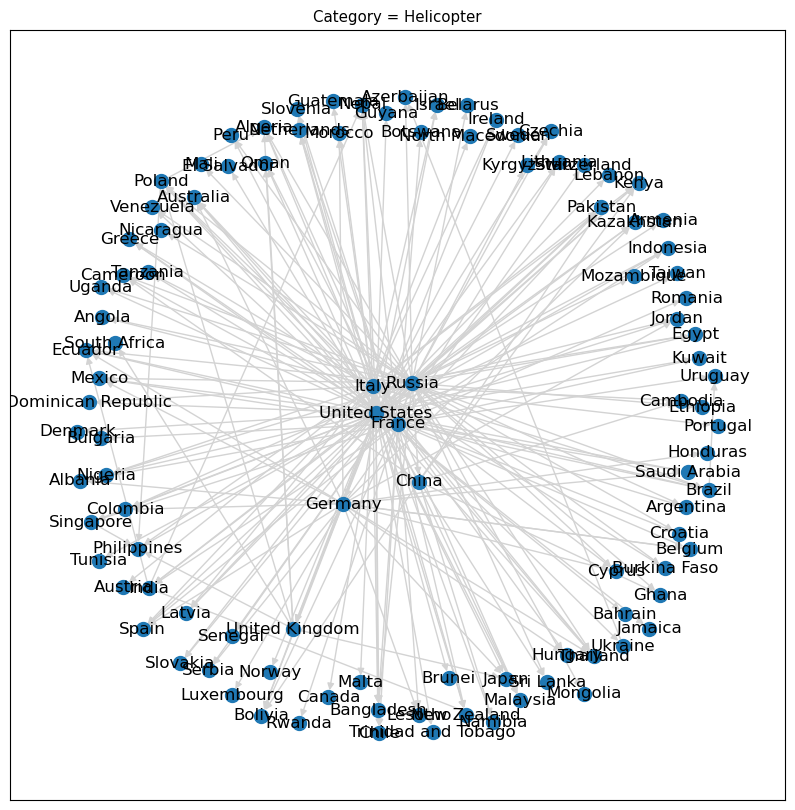

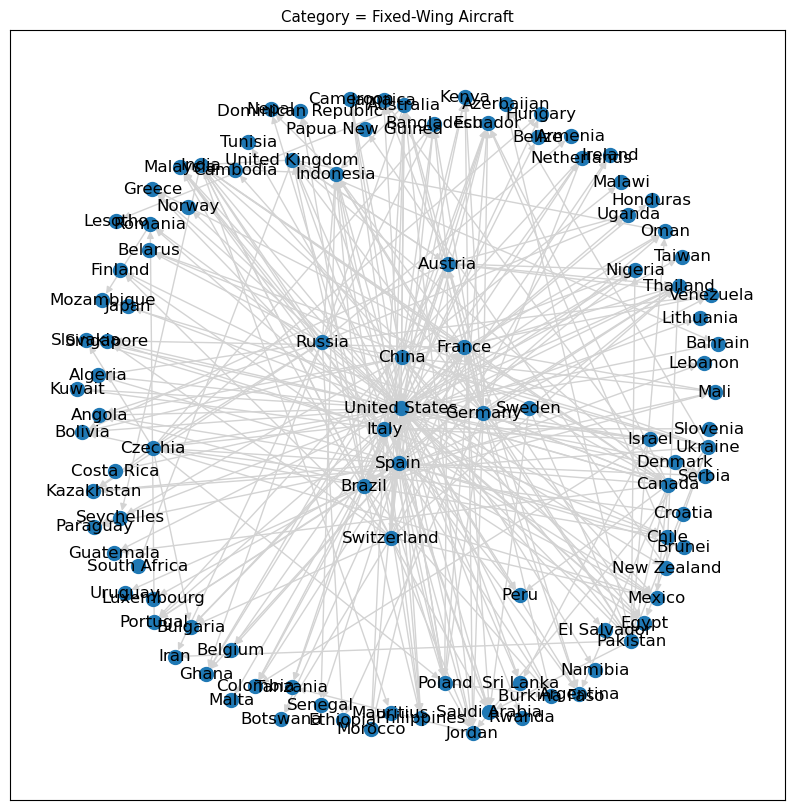

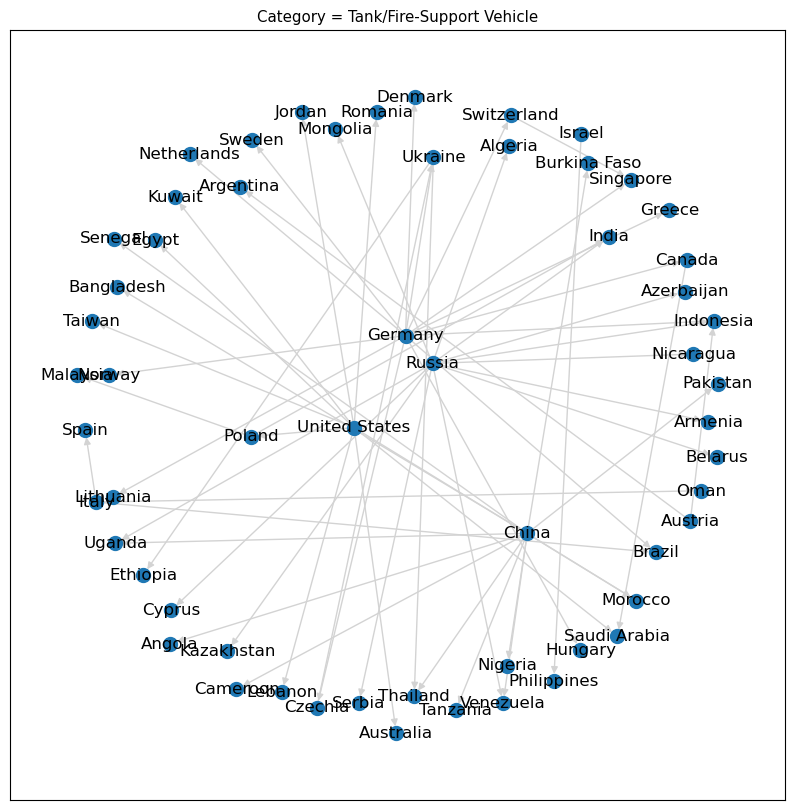

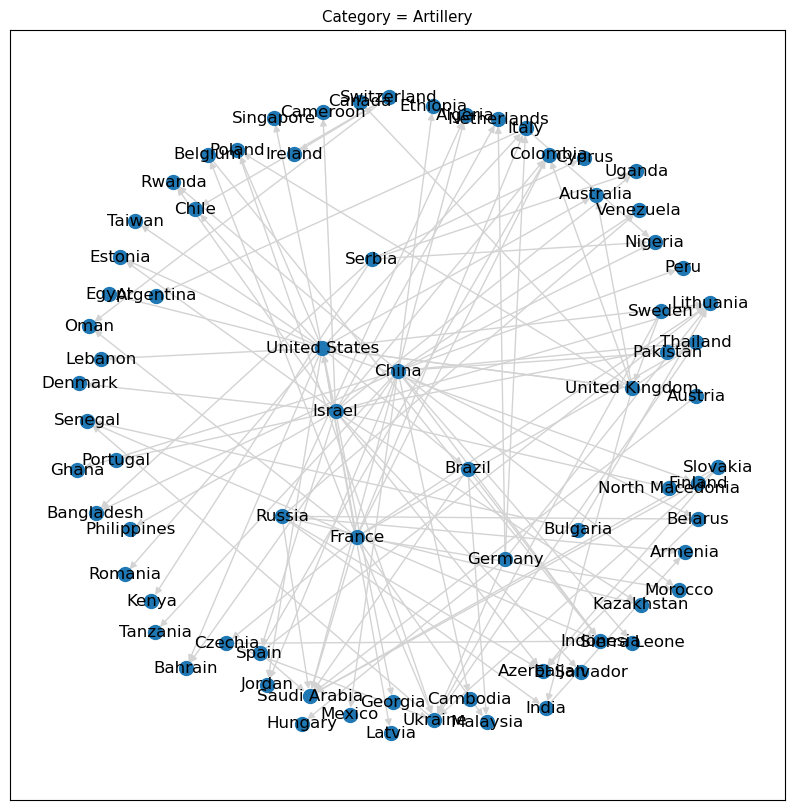

In [ ]:
def print_graph(full_df,all_designations):
    for weapon_designation in all_designations:
        this_network = create_network(full_df[full_df['Weapon description'] == weapon_designation])  
        plt.figure(figsize=(10,10))
        this_network.remove_nodes_from(list(nx.isolates(this_network)))
        plt.title("Category = " + weapon_designation)
        pos = nx.spring_layout(this_network,k=1.5, center=(1,1),weight=3)
        nx.draw_networkx(this_network, pos=pos, with_labels=True,node_size=100,edge_color='#D3D3D3')
        plt.show()

print_graph(full_df,investigating_categories)